In [60]:
from pathlib import Path
import compiler_gym
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import pdb

from compiler_gym_dataset import CompilerGymDataset, fast_networkx_to_dgl
# from model_gnn import GNNEncoder

device = 'cuda'

In [99]:
root_path = os.environ.get("COMPILER2_ROOT")
db_path = Path(root_path + "/results/random-compiler2-v0/2022-05-03/11-44-16/1567088/results.pkl")

print(db_path)
print(f"Is file good = {db_path.is_file()}")

/home/dx4/tools/compiler2/results/random-compiler2-v0/2022-05-03/11-44-16/1567088/results.pkl
Is file good = True


In [100]:
env = compiler_gym.make("llvm-v0")
print(f'Number of actions = {len(env.action_space.flags)}')

Number of actions = 124


./compiler_gym-llvm-service: /lib64/libtinfo.so.5: no version information available (required by ./compiler_gym-llvm-service)


In [101]:
with open(db_path, 'rb') as f:
    df = pickle.load(f)
print(df.shape)
df.head()


(8, 6)


,BenchmarkName,State,NextState,Action,CommandLine,Reward
0,benchmark://poj104-v0/28_982,"[[488032.0, 1119591.0, 0.5, 273635.0, 0.0, 0.0...","[[358202.0, 1372654.0, 0.68, 273562.0, 0.0, 0....",-instnamer,opt -sroa -loop-predication -lower-widenable-c...,0.266028
1,benchmark://poj104-v0/28_982,"[[743687.0, 1381124.0, 0.67, 273553.0, 0.0, 0....","[[527039.0, 1503405.0, 0.66, 273635.0, 0.0, 0....",-strip-nondebug,opt -sroa -loop-predication -lower-widenable-c...,0.291316
2,benchmark://poj104-v0/28_982,"[[315928.0, 1101632.0, 0.55, 273569.0, 0.0, 0....","[[421499.0, 1247572.0, 0.54, 273623.0, 0.0, 0....",-inferattrs,opt -sroa -loop-predication -lower-widenable-c...,-0.334162
3,benchmark://poj104-v0/28_982,"[[421499.0, 1247572.0, 0.54, 273623.0, 0.0, 0....","[[319836.0, 1282263.0, 0.57, 273552.0, 0.0, 0....",-inferattrs,opt -sroa -loop-predication -lower-widenable-c...,0.241194
4,benchmark://poj104-v0/28_982,"[[319836.0, 1282263.0, 0.57, 273552.0, 0.0, 0....","[[443580.0, 1716408.0, 0.76, 273553.0, 0.0, 0....",-inferattrs,opt -sroa -loop-predication -lower-widenable-c...,-0.386898


In [102]:
df['State'][0]

[array([4.880320e+05, 1.119591e+06, 5.000000e-01, 2.736350e+05,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 5.200000e-01,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 6.100000e+01,
        6.100000e+01, 5.097000e+03, 1.807200e+04, 2.134000e+03,
        1.084860e+05, 2.806000e+03, 8.750000e+02, 4.719200e+04,
        6.400200e+04, 4.904000e+03, 4.904000e+03, 6.400200e+04,
        2.530000e+02, 6.210000e+02, 9.600000e+01, 6.000000e+00]),

In [51]:
vocab = {}
cnt = 0
for i in graph.nodes:
    if 'features' in graph.nodes[i]:
        if 'full_text' in graph.nodes[i]['features']:
            inst = graph.nodes[i]['features']['full_text'][0]
            vocab[inst] = cnt
            cnt += 1            

In [52]:
vocab

{'%2 = alloca i32*, align 8, !dbg !112': 0,
 'call void @llvm.dbg.value(metadata i32** %2, metadata !11, metadata !DIExpression()), !dbg !112': 1,
 '%3 = alloca i32, align 4, !dbg !113': 2,
 'call void @llvm.dbg.value(metadata i32* %3, metadata !13, metadata !DIExpression()), !dbg !113': 3,
 '%4 = alloca i32, align 4, !dbg !114': 4,
 'call void @llvm.dbg.value(metadata i32* %4, metadata !14, metadata !DIExpression()), !dbg !114': 5,
 '%5 = alloca i32, align 4, !dbg !115': 6,
 'call void @llvm.dbg.value(metadata i32* %5, metadata !15, metadata !DIExpression()), !dbg !115': 7,
 '%6 = alloca i32, align 4, !dbg !116': 8,
 'call void @llvm.dbg.value(metadata i32* %6, metadata !16, metadata !DIExpression()), !dbg !116': 9,
 '%7 = alloca i32, align 4, !dbg !117': 10,
 'call void @llvm.dbg.value(metadata i32* %7, metadata !17, metadata !DIExpression()), !dbg !117': 11,
 '%8 = alloca i32, align 4, !dbg !118': 12,
 'call void @llvm.dbg.value(metadata i32* %8, metadata !18, metadata !DIExpression

In [54]:
dataset = CompilerGymDataset(graph, vocab=vocab, dataset_size=1)
# graph = df['State'][0]

# dgl_graph = fast_networkx_to_dgl(g)

using filepath:  None
using:  None  as dataset


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [25]:
graph.nodes(data="type")

NodeDataView({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 1, 30: 0, 31: 1, 32: 0, 33: 0, 34: 1, 35: 0, 36: 0, 37: 1, 38: 0, 39: 0, 40: 1, 41: 0, 42: 1, 43: 0, 44: 0, 45: 1, 46: 0, 47: 0, 48: 1, 49: 0, 50: 0, 51: 1, 52: 0, 53: 1, 54: 0, 55: 0, 56: 1, 57: 0, 58: 0, 59: 1, 60: 0, 61: 0, 62: 1, 63: 0, 64: 1, 65: 0, 66: 0, 67: 1, 68: 0, 69: 0, 70: 1, 71: 0, 72: 0, 73: 1, 74: 0, 75: 0, 76: 1, 77: 0, 78: 0, 79: 1, 80: 1, 81: 0, 82: 0, 83: 1, 84: 0, 85: 0, 86: 1, 87: 0, 88: 0, 89: 1, 90: 1, 91: 0, 92: 0, 93: 1, 94: 0, 95: 0, 96: 1, 97: 0, 98: 0, 99: 1, 100: 1, 101: 0, 102: 0, 103: 1, 104: 0, 105: 1, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 1, 112: 0, 113: 0, 114: 1, 115: 0, 116: 1, 117: 0, 118: 0, 119: 1, 120: 0, 121: 0, 122: 1, 123: 0, 124: 0, 125: 1, 126: 0, 127: 1, 128: 0, 129: 0, 130: 1, 131: 0, 132: 0, 133: 1, 134: 0, 135: 0, 136: 1, 

In [55]:
import dgl
import numpy as np
import torch
from dgl.data import DGLDataset

In [56]:
# def fast_networkx_to_dgl(
#     graph, node_attrs=["text_idx", "type"], edge_attrs=["flow", "position"]
# ):
#     """
#     Takes a networkx graph and its given node attributes and edge attributes
#     and converts it corresponding dgl graph
#     Inputs:
#         - graph: the networkx graph
#         - node_attrs: node attributes to convert
#         - edge_attrs: edge attributes to convert
#     """

node_attrs=["text_idx", "type"]
node_attrs=["type"]
edge_attrs=["flow", "position"]


edges = [edge for edge in graph.edges()]
dgl_graph = dgl.graph(edges, num_nodes=graph.number_of_nodes())

for feat in edge_attrs:
    edge_assigns = torch.tensor(
        [val[-1] for val in graph.edges(data=feat)], dtype=torch.int64
    )
    dgl_graph.edata[feat] = edge_assigns

for feat in node_attrs:
    node_assigns = torch.tensor(
        [val[-1] for val in graph.nodes(data=feat)], dtype=torch.int64
    )
    dgl_graph.ndata[feat] = node_assigns

dgl_graph

Graph(num_nodes=552, num_edges=1099,
      ndata_schemes={'type': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'flow': Scheme(shape=(), dtype=torch.int64), 'position': Scheme(shape=(), dtype=torch.int64)})

In [18]:
dgl_graph

Graph(num_nodes=552, num_edges=1099,
      ndata_schemes={}
      edata_schemes={})

In [21]:
columns = ["BenchmarkName", "State", "NextState", "Action", "CommandLine", "Reward"]
# df = pd.read_csv(db_path, names=columns, header=1)
with open(db_path, 'rb') as f:
    df = pickle.load(f)

# df['State'] = df['State'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['State']),0)
state_max = np.max(np.stack(df['State']),0)
df['State'] = df['State'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['State'] = df['State'].apply(lambda x:torch.tensor(x).float())

# df['NextState'] = df['NextState'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['NextState']),0)
state_max = np.max(np.stack(df['NextState']),0)
df['NextState'] = df['NextState'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['NextState'] = df['NextState'].apply(lambda x:torch.tensor(x).float())


action_kinds = pd.Categorical(df['Action'], categories=env.action_space.flags)
action_one_hot = pd.get_dummies(action_kinds)

df = df.dropna()
df['Action'] = action_one_hot.values.tolist()
df['Action'] = df['Action'].apply(lambda x: torch.tensor(x).float())
df['Reward'] = df['Reward'].apply(lambda x: torch.tensor(x).float())

df.head()

,BenchmarkName,State,NextState,Action,CommandLine,Reward
0,benchmark://poj104-small-v0/1_17,"[tensor(0.), tensor(0.7968), tensor(0.7143), t...","[tensor(0.), tensor(0.7968), tensor(0.7143), t...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -always-inline -jump-threading -reg2mem -d...,tensor(0.)
1,benchmark://poj104-small-v0/1_79,"[tensor(0.), tensor(0.7968), tensor(0.7143), t...","[tensor(1.), tensor(0.), tensor(0.), tensor(1....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -always-inline -jump-threading -reg2mem -d...,tensor(0.)
2,benchmark://poj104-small-v0/1_79,"[tensor(1.), tensor(0.), tensor(0.), tensor(1....","[tensor(1.), tensor(0.), tensor(0.), tensor(1....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -always-inline -jump-threading -reg2mem -d...,tensor(0.)
3,benchmark://poj104-small-v0/2_5,"[tensor(1.), tensor(0.), tensor(0.), tensor(1....","[tensor(0.8924), tensor(1.), tensor(1.), tenso...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -always-inline -jump-threading -reg2mem -d...,tensor(0.)
4,benchmark://poj104-small-v0/2_5,"[tensor(0.8924), tensor(1.), tensor(1.), tenso...","[tensor(0.8924), tensor(1.), tensor(1.), tenso...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",opt -always-inline -jump-threading -reg2mem -d...,tensor(0.)


In [24]:
class experienceDataset(Dataset):
    def __init__(self,experience):
        self.experience = experience
    def __getitem__(self, i):
        # return S,A,R,S'
        return self.experience['State'].iloc[i].to(device), \
               self.experience['Action'].iloc[i].to(device), \
               self.experience['Reward'].iloc[i].to(device), \
               self.experience['NextState'].iloc[i].to(device)

    def __len__(self):
        return self.experience.shape[0]

In [25]:
class Q_net(nn.Module):
    def __init__(self,in_size,out_size,hidden_size,dropout):
        super(Q_net,self).__init__()
        self.l1 = nn.Linear(in_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,hidden_size)
        self.l4 = nn.Linear(hidden_size,hidden_size)
        self.l5 = nn.Linear(hidden_size,hidden_size)
        self.l6 = nn.Linear(hidden_size,hidden_size)
        self.l7 = nn.Linear(hidden_size,out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l2(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l3(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l4(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l5(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l6(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        return self.l7(x)

In [26]:
test_size = len(df) // 5
train_size = len(df) - test_size
experience = experienceDataset(df)
train_set, test_set = torch.utils.data.random_split(experience, [train_size, test_size])
batch_size = 1000
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)
policy_net = Q_net(28,124,512,0.5).to(device)
target_net = Q_net(28,124,512,0.5).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
train_losses = []
test_losses = []
num_epochs = 301
test_every = 5
gamma = 0.9

In [32]:
for epoch in tqdm(range(num_epochs)):
    # loop_inner = tqdm(total=train_size//batch_size,position=0,leave=False)
    policy_net.train()
    for S,A,R,S_ in trainLoad:
        r = torch.sum(torch.mul(policy_net(S),A),1)
        r_hat = 1 + torch.max(target_net(S_),1).values * gamma
                
        loss = criterion(r,r_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    #     loop_inner.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
    #     loop_inner.update(1)
    # loop_inner.close()
    if epoch % test_every == 0:
        with torch.no_grad():
            policy_net.eval()
            for S,A,R,S_ in trainLoad:
                r = torch.sum(torch.mul(policy_net(S),A),1)
                r_hat = R + torch.max(target_net(S_),1).values * gamma

                loss = criterion(r,r_hat)
                test_losses.append(loss.item())
    target_net.load_state_dict(policy_net.state_dict())

100%|██████████| 301/301 [00:01<00:00, 208.75it/s]


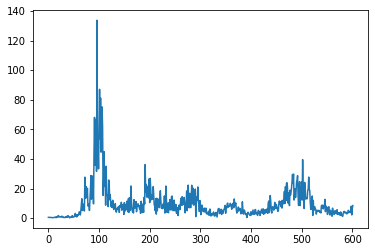

In [33]:
plt.figure(facecolor='white')
plt.plot(train_losses)

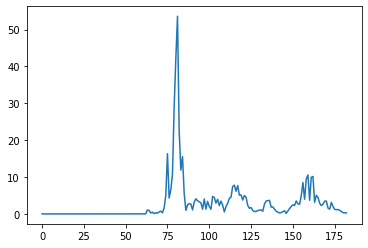

In [34]:
plt.figure(facecolor='white')
plt.plot(test_losses)

In [35]:
def get_action(state,network,epsilon):
    p = random.random()
    if p > epsilon:
        with torch.no_grad():
            return torch.max(network(state),1).indices[0].item()
    else:
        return random.randint(0,124)

In [36]:
get_action(df['State'].iloc[0],target_net,1)

9

In [37]:
get_action(df['State'].iloc[0].unsqueeze(0).to(device),target_net,0)

58

In [225]:

output_pt_path = db_path.parent/'deep_q.pt'
model_scripted = torch.jit.script(target_net) # Export to TorchScript
model_scripted.save(output_pt_path) # Save

print(f"Saved at: {output_pt_path}")

Saved at: /home/dx4/tools/compiler2/results/random-compiler2-v0/2022-04-14/21-04-48/3258200/deep_q.pt
